In [8]:
from ecell4 import *
import numpy as np
import math
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from ecell4.extra import ensemble
from math import sqrt,pi,log

def wrap(job,job_id,task_id):
    def singlerun(kaf,kr,run,correct,L,Na,Da,Db,duration):
        import numpy as np
        from math import sqrt    
        rng = GSLRandomNumberGenerator()
        rng.seed(run)        
        rm = 0.005
        D = Da+Db
        ka = kaf*D
        f=1.0208582         
        voxelr=rm*f
        if correct=='new':
            gamma=0.577216
            factor = (2 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0) + sqrt(22.0))**2/(72 * (6 * sqrt(2.0) + 4 * sqrt(3.0) + 3 * sqrt(6.0)))            
            PP=1./(1+math.sqrt(3)*(math.log(f*f/12)+(4*math.pi*D/ka)-2*gamma)/2/math.pi)
            ka = PP*D/factor            
        tm =(2*voxelr)**2/(4*Da)        
        H = 3*voxelr*2
        ori = Real3(0.5*H,0,0)
        unit0 = Real3(0,0,L)
        unit1 = Real3(0,L,0)
        w = spatiocyte.SpatiocyteWorld(Real3(H,L,L),voxelr,rng)
        Nb=Na#int(5*Na)
        w.add_structure(Species('M'),PlanarSurface(ori,unit0,unit1))
        with species_attributes():
            A |  {'D': str(Da), 'radius':str(voxelr),'location':'M'}
            B |  {'D': str(Db), 'radius':str(voxelr),'location':'M'}
            C |  {'D': str(Db), 'radius':str(voxelr),'location':'M'}

        with reaction_rules():
            A + B == C | (ka,kr)

        m2 = get_model()
        w.bind_to(m2)
        w.add_molecules(Species('A'), Na)
        w.add_molecules(Species('B'), Nb)
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        tfactor=1
        obs = FixedIntervalNumberObserver(duration/100,['A'])
        sim.run(duration,obs)       
        data=obs.data()
        return data
    job.update({'run':task_id})
    out=singlerun(**job)
    return out

def runode(kaf,kr,run,correct,L,Na,Da,Db,duration,opt):
    rm = 0.005
    D = Da+Db
    tm =(2*rm)**2/(4*Da)        
    ka = kaf*D
    Nb=Na#int(5*Na)
    Area=L**2
    CB=Nb/Area
    R=2*rm
    phi=pi*R*R*CB
    kappa=ka/D
    kss=4*pi*D/(np.log(2)-2*gamma-np.log(phi)+4*pi/kappa)        
    b=2*sqrt(1./pi/CB+R*R)
    kss2= 1./(1./ka+(4*log(b/R)/(1-(R/b)**2)**2-2./(1-(R/b)**2)-1)/(8*pi*D))    
    kD= ka/kr
    if opt=='our':
        kon=kss
    elif opt=='ka':
        kon=ka
    else:
        kon=kss2
    koff = kon/kD
    with reaction_rules():
        A + B == C | (kon,koff)
    m2 = get_model()    
    L=np.cbrt(Area)
    w = ode.ODEWorld(Real3(L, L,L))
    w.bind_to(m2)
    w.add_molecules(Species('A'), Na)
    w.add_molecules(Species('B'), Nb)
    sim = ode.ODESimulator(w)
    sim.initialize()
    tfactor=1
    obs = FixedIntervalNumberObserver(duration/100,['A'])
    sim.run(duration,obs)       
    data=obs.data()
    tt=np.array(data).T[0]
    NN=np.array(data).T[1]
    return tt,NN

(0, 1000)

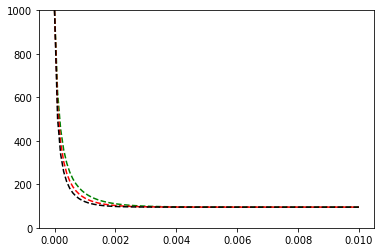

In [10]:
kaf=5#00
kr = 100
L=1.
Da=1
Db=1
N=1000
gamma = 0.5772156    
f=1.0208582      
cor='new'
dur=0.01
simrun=15
nproc=50

to1,no1 = runode(kaf,kr,1,cor,L,N,Da,Db,dur,'others')
plt.plot(to1,no1,'g--',label='ode others')
to2,no2 = runode(kaf,kr,1,cor,L,N,Da,Db,dur,'our')
plt.plot(to2,no2,'r--',label='ode our')
to2,no2 = runode(kaf,kr,1,cor,L,N,Da,Db,dur,'ka')
plt.plot(to2,no2,'k--',label='ode ka')
plt.ylim(0,1000)



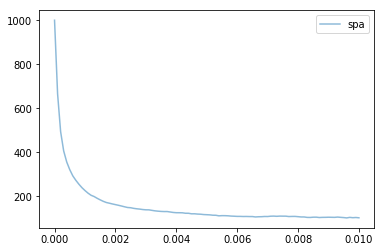

In [5]:
jobs=[{'kaf':kaf,'kr':kr,'correct':cor,'Na':N,'L':L,'Da':Da,'Db':Db,'duration':dur}]    
#nsemble.run_slurm(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'),extra_args=['--exclude=ibc[01,02,12,27]'])[0]
out=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
dspa=np.array(out)
ts,ns=np.mean(dspa,axis=0).T
plt.plot(ts,ns,'-',label='spa',alpha=0.5)
#plt.title('kaf='+str(kaf)+'N='+str(N))
plt.legend()

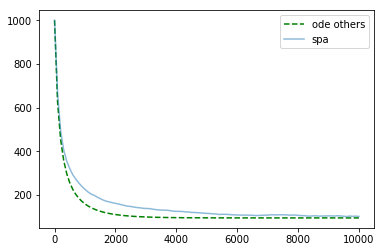

In [6]:
plt.plot(to1/1e-6,no1,'g--',label='ode others')
plt.plot(ts/1e-6,ns,'-',label='spa',alpha=0.5)
#plt.title('kaf='+str(kaf)+'N='+str(N))

plt.legend()

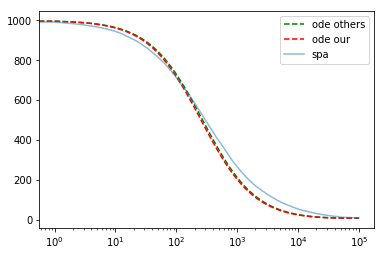

In [28]:
plt.plot(to1/1e-6,no1,'g--',label='ode others')
plt.plot(to2/1e-6,no2,'r--',label='ode our')
plt.plot(ts/1e-6,ns,'-',label='spa',alpha=0.5)
#plt.title('kaf='+str(kaf)+'N='+str(N))
plt.xscale('log')
plt.legend()

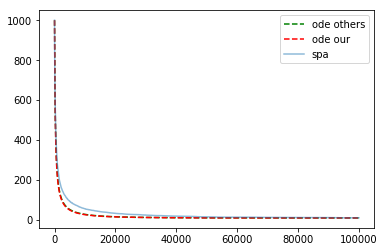

In [29]:
plt.plot(to1/1e-6,no1,'g--',label='ode others')
plt.plot(to2/1e-6,no2,'r--',label='ode our')
plt.plot(ts/1e-6,ns,'-',label='spa',alpha=0.5)
#plt.title('kaf='+str(kaf)+'N='+str(N))
plt.legend()